## 네이버 리뷰 감상 분석

## Library & Data Set Load

In [1]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Word 관련 
import konlpy
import gensim
from konlpy.tag import Mecab
from gensim.models.keyedvectors import Word2VecKeyedVectors


# 텐서플로
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant


In [2]:
train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')

display(train_data.shape)
display(train_data.head())

(150000, 3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## Data Loader

In [3]:
tokenizer = Mecab()

In [4]:
#stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 10000

In [5]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True) # 중복 제거 
    test_data = test_data.dropna(how = 'any')  # 결측치 제거
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
#       temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
#       temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    
    special_words = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>']
    vocab = special_words + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words)

In [6]:
print(len(X_train),len(y_train) ,len(X_test) , len(y_test))

146182 146182 49157 49157


In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [9]:
for i in range(10):
    j = random.randint(0,len(X_train))
    print(X_train[j])
    print(get_decoded_sentence(X_train[j],index_to_word))
    print("Label:", y_train[i])
## 램덤하게 샘플 분석 결과 특수 문자는 의미가 있음

[8555, 8, 4, 19, 1234, 13, 117, 26, 6, 149, 1666, 28]
다 . .. 모 가 잼 있 는 건 쥐 ?
Label: 0
[6436, 74, 134, 12, 6995, 963, 1009, 2121, 2, 1041, 2, 2]
와 하나 의 버디 무비 소녀 버전 <UNK> 온 <UNK> <UNK>
Label: 1
[2300, 4318, 14, 212, 14, 166, 183, 21, 9968, 4318, 12, 2806, 16, 1465, 24, 437, 9, 21, 1296, 697, 10, 8]
디자인 은 괜찮 은 편 인데 , 메카 디자인 의 장점 을 살리 지 못하 고 , 여전히 엉성 하 다
Label: 0
[3780, 8, 142, 4, 19, 83]
다 이건 . .. ㅋㅋㅋ
Label: 0
[453, 77, 5, 173, 13, 406, 59, 198, 15, 310, 930, 5, 323, 27, 8, 4, 563, 170, 401, 10, 9, 173, 76, 1116, 6]
왜 이 이야기 가 시작 되 는지 에 대한 설명 이 전혀 없 다 . 개연 성 부족 하 고 이야기 할 거리 는
Label: 1
[2805, 332, 112, 69, 107, 86, 59, 6, 166, 4, 409, 30, 101, 6142, 74, 2560, 3290, 25, 18, 7, 52, 317, 104, 58, 26, 153, 48, 4]
시리즈 중 최고 라 생각 되 는 편 . 특히 나 알 파치노 와 로버트 드니로 를 한 영화 에서 모두 볼 수 있 다는 점 .
Label: 0
[1866, 91, 22, 32, 101, 32, 18, 103, 21, 4217, 335, 1794, 1947, 7]
사람 들 만 알 만 한 내용 , 고로 표현 력 제로 영화
Label: 0
[168, 37, 2, 9, 66, 102, 31, 44, 23, 218]
안 <UNK> 고 잘 만들 었 네요 ! ㅎㅎ
Label: 0
[80, 52, 651, 308, 420, 

## 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

### 데이터셋 내 문장 길이 분포(1)

In [10]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  18.722948310373248
문장길이 최대 :  116
문장길이 표준편차 :  15.329465639810111
pad_sequences maxlen :  49
전체 문장의 0.9346725436292804%가 maxlen 설정값 이내에 포함됩니다. 


### 데이터셋 내 문장 길이 분포(2)
 - X_train, X_test Length -> Dataframe 
 - Describe & Countplot  

In [11]:
# 리스트 길이 리스트로 만들어주는 함수 이용(X_train+X_test)
def get_list_length(data):
    l_len = []
    for i,l in enumerate(data):
        l_len.append([i,len(l)])
    return l_len

list_len = []
for l_list in [X_train,X_test]:
    list_len += get_list_length(l_list)

In [12]:
df_len = pd.DataFrame(list_len,columns=['Idx','Length'])
df_len.describe(percentiles=[0,1/4,1/2,3/4,9/10,95/100,99/100,999/1000]).T

,count,mean,std,min,0%,25%,50%,75%,90%,95%,99%,99.9%,max
Idx,195339.0,60882.344115,42737.903271,0.0,0.0,24417.0,48834.0,97346.5,126647.2,136414.1,144227.62,145985.662,146181.0
Length,195339.0,18.722948,15.329505,1.0,1.0,9.0,14.0,22.0,39.0,56.0,72.00,83.000,116.0


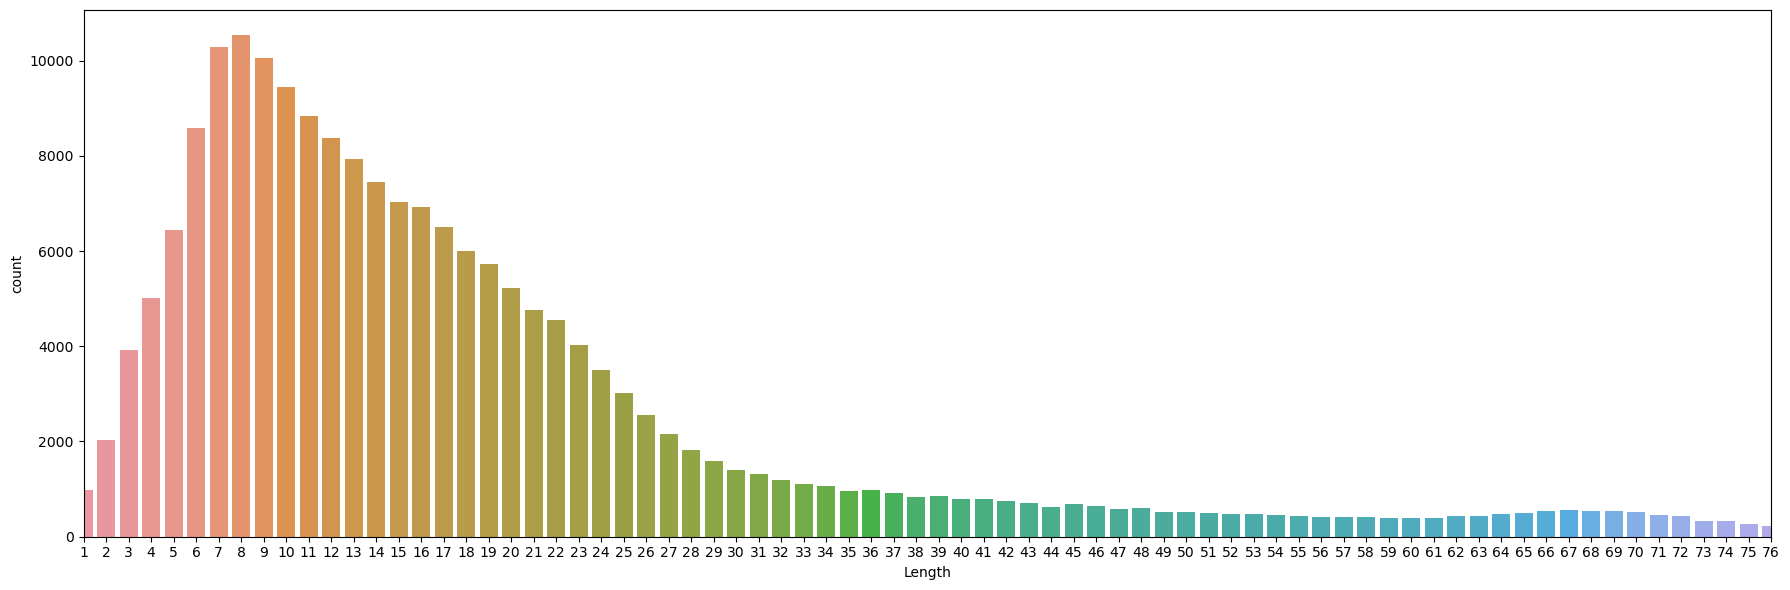

In [13]:
fig,ax = plt.subplots(figsize=(18,6))
sns.countplot(data=df_len, x='Length',ax=ax)
plt.xlim([0,75])
plt.tight_layout()
plt.show()

- 95%    : 56
- 99%    : 72
- 99.99% : 83

### 적절한 최대 문장 길이 지정


In [14]:
maxlen = 72 # 위 분포로 봤을 때 72로 설정하면 99% 커버 
vocab_size = len(word_to_index) #현, 10000개
word_vector_dim = 16

### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [15]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

## 모델 구성 및 Validation Set. 구성

### 사전 데이터 변수 확인

In [16]:
print(maxlen)       # 문장 최대 길이 : 75, 99% 커버 
print(vocab_size)    # 단어집 사이즈  : 10000개 테스트 
print(word_vector_dim) # 차원 :16

61
10000
16


### 모델용 데이터 분리 

분리 값 : partial_val
len(X_train) * 0.2

In [17]:
partial_val = int(len(X_train) * 0.2)

In [18]:
x_val = X_train[:partial_val] 
y_val = y_train[:partial_val]

# validation set을 제외한 나머지 80%
partial_x_train = X_train[partial_val:]
partial_y_train = y_train[partial_val:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(116946, 61)
(116946,)


### LSTM

In [19]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm_model.add(tf.keras.layers.LSTM(64))                        # 8 - 과적합 현상 발생 -> 16 -> 64 로 조정
lstm_model.add(tf.keras.layers.Dense(8, activation='relu'))
lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

lstm_model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 181,265
Trainable params: 181,265
Non-trainable params: 0
_________________________________________________________________


In [20]:
early_stop = EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=7) # Patience : Loss Graph 값의 증가 패턴을 보고 과적합 방지 위해 
                                                                                  # 10-> 7로 조정. 타 모델도 30% -
lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50

history = lstm_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/50


2023-05-24 08:21:55.688145: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


229/229 [==============================] - 37s 159ms/step - loss: 0.4825 - accuracy: 0.7697 - val_loss: 0.3534 - val_accuracy: 0.8476
Epoch 2/50
229/229 [==============================] - 36s 158ms/step - loss: 0.3380 - accuracy: 0.8565 - val_loss: 0.3472 - val_accuracy: 0.8505
Epoch 3/50
229/229 [==============================] - 34s 150ms/step - loss: 0.3186 - accuracy: 0.8670 - val_loss: 0.3446 - val_accuracy: 0.8520
Epoch 4/50
229/229 [==============================] - 35s 153ms/step - loss: 0.3059 - accuracy: 0.8735 - val_loss: 0.3454 - val_accuracy: 0.8510
Epoch 5/50
229/229 [==============================] - 36s 156ms/step - loss: 0.2975 - accuracy: 0.8775 - val_loss: 0.3510 - val_accuracy: 0.8523
Epoch 6/50
229/229 [==============================] - 36s 158ms/step - loss: 0.2847 - accuracy: 0.8833 - val_loss: 0.3592 - val_accuracy: 0.8508
Epoch 7/50
229/229 [==============================] - 35s 154ms/step - loss: 0.2700 - accuracy: 0.8904 - val_loss: 0.3468 - val_accuracy: 0.8

In [21]:
lstm_results = lstm_model.evaluate(X_test,  y_test, verbose=2)
lstm_history_dict = history.history
print(lstm_results)

1537/1537 - 13s - loss: 0.3545 - accuracy: 0.8496 - 13s/epoch - 8ms/step
[0.35449010133743286, 0.8496450185775757]


In [54]:
# loss: 0.3545 - accuracy: 0.8496  - 불용어 제거, Patient 조정 효과

### 1-D Convolution Neural Network(1-D CNN)

In [22]:
dcnn_model = tf.keras.Sequential()
dcnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
dcnn_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
dcnn_model.add(tf.keras.layers.MaxPooling1D(5))
dcnn_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
dcnn_model.add(tf.keras.layers.GlobalMaxPooling1D())
dcnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
dcnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

dcnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 conv1d (Conv1D)             (None, None, 16)          1808      
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                

In [23]:
early_stop = EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=4)    # 10-> 5-> 4 로 조정

dcnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  

history = dcnn_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
229/229 [==============================] - 30s 131ms/step - loss: 0.4975 - accuracy: 0.7538 - val_loss: 0.3501 - val_accuracy: 0.8461
Epoch 2/50
229/229 [==============================] - 27s 119ms/step - loss: 0.3217 - accuracy: 0.8636 - val_loss: 0.3307 - val_accuracy: 0.8574
Epoch 3/50
229/229 [==============================] - 27s 118ms/step - loss: 0.2846 - accuracy: 0.8822 - val_loss: 0.3300 - val_accuracy: 0.8587
Epoch 4/50
229/229 [==============================] - 25s 109ms/step - loss: 0.2541 - accuracy: 0.8973 - val_loss: 0.3382 - val_accuracy: 0.8572
Epoch 5/50
229/229 [==============================] - 25s 109ms/step - loss: 0.2239 - accuracy: 0.9123 - val_loss: 0.3514 - val_accuracy: 0.8554
Epoch 5: early stopping


In [24]:
dcnn_results = dcnn_model.evaluate(X_test,  y_test, verbose=2)
dcnn_history_dict = history.history

print(dcnn_results)

1537/1537 - 4s - loss: 0.3647 - accuracy: 0.8489 - 4s/epoch - 3ms/step
[0.364749550819397, 0.8488516211509705]


In [ ]:
# loss: 0.3647 - accuracy: 0.8489

### GlobalMaxPooling1D()

In [25]:
gmp_model = tf.keras.Sequential()
gmp_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gmp_model.add(tf.keras.layers.GlobalMaxPooling1D())
gmp_model.add(tf.keras.layers.Dense(8, activation='relu'))
gmp_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

gmp_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160000    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [26]:
early_stop = EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=7)

gmp_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = gmp_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
229/229 [==============================] - 9s 40ms/step - loss: 0.5993 - accuracy: 0.7566 - val_loss: 0.4425 - val_accuracy: 0.8203
Epoch 2/50
229/229 [==============================] - 3s 15ms/step - loss: 0.3829 - accuracy: 0.8382 - val_loss: 0.3614 - val_accuracy: 0.8400
Epoch 3/50
229/229 [==============================] - 3s 11ms/step - loss: 0.3270 - accuracy: 0.8623 - val_loss: 0.3487 - val_accuracy: 0.8462
Epoch 4/50
229/229 [==============================] - 2s 10ms/step - loss: 0.2976 - accuracy: 0.8767 - val_loss: 0.3479 - val_accuracy: 0.8476
Epoch 5/50
229/229 [==============================] - 2s 10ms/step - loss: 0.2759 - accuracy: 0.8875 - val_loss: 0.3513 - val_accuracy: 0.8481
Epoch 6/50
229/229 [==============================] - 2s 9ms/step - loss: 0.2578 - accuracy: 0.8964 - val_loss: 0.3578 - val_accuracy: 0.8480
Epoch 7/50
229/229 [==============================] - 2s 9ms/step - loss: 0.2425 - accuracy: 0.9041 - val_loss: 0.3656 - val_accuracy: 0.8478
E

In [27]:
gmp_results = gmp_model.evaluate(X_test,  y_test, verbose=2)
gmp_history_dict = history.history

print(gmp_results)

1537/1537 - 4s - loss: 0.3868 - accuracy: 0.8406 - 4s/epoch - 3ms/step
[0.38680386543273926, 0.8406330943107605]


In [ ]:
# loss: 0.3868 - accuracy: 0.8406

### 각 모델별 Loss & Accuracy 분석

In [28]:
model_dic = {'lstm_model':lstm_model,'dcnn_model':dcnn_model,'gmp_model':gmp_model}
model_list = list(model_dic.values())
model_name_list = list(model_dic.keys())
history_list = [lstm_history_dict,dcnn_history_dict ,gmp_history_dict]

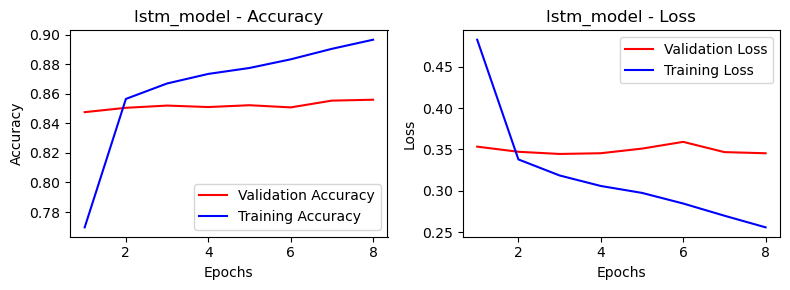

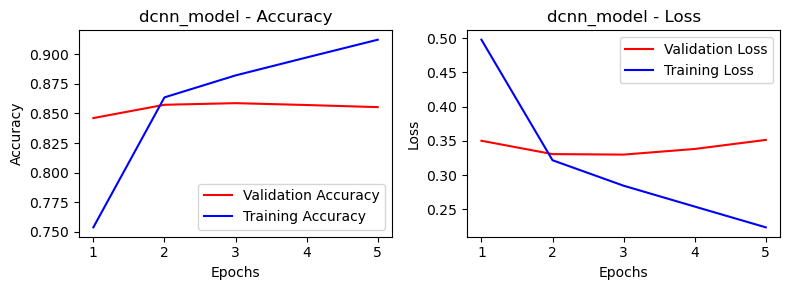

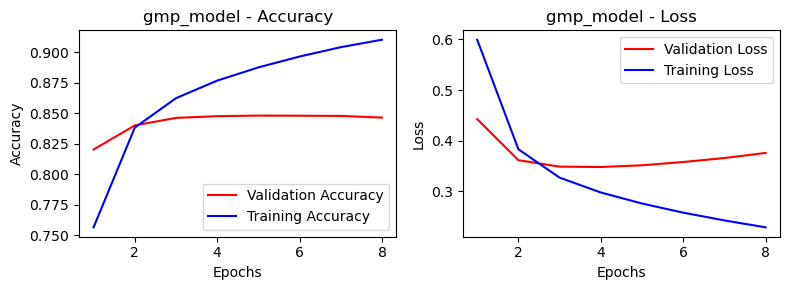

In [29]:
for i, history_dict in enumerate(history_list):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(acc) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(8, 3))

    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs, y=val_acc, c='r', label='Validation Accuracy')
    sns.lineplot(x=epochs, y=acc, c='b', label='Training Accuracy')
    plt.title('{} - Accuracy'.format(model_name_list[i]))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs, y=val_loss, c='r', label='Validation Loss')
    sns.lineplot(x=epochs, y=loss, c='b', label='Training Loss')
    plt.title('{} - Loss'.format(model_name_list[i]))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

## 학습된 Embedding 레이어 분석


In [30]:
word2vec_file_path = './data/word2vec.txt'

In [31]:
model_dic = {'lstm_model':lstm_model,'dcnn_model':dcnn_model,'gmp_model':gmp_model}
model_list = list(model_dic.values())
model_name_list = list(model_dic.keys())

In [32]:
for i,model in enumerate(model_list):
    print('{} 모델 '.format(model_name_list[i]))
    print('...............................')
    # 임베딩 레이어 차원 확인
    embedding_layer = model.layers[0]
    weights = embedding_layer.get_weights()[0]
    #print(weights.shape)    # shape: (vocab_size, embedding_dim)
    
    word2vec_file_path = './data/word2vec_{}.txt'.format(model_name_list[i])

    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록
    vectors = model.get_weights()[0]
    for i in range(4,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()
    
    word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

    # 유사한 단어와 그 유사도 확인
    print('슬픈 의 유사 단어 및 유사도')
    display(word_vectors.similar_by_word("슬픈"))
    print('봉준호 의 유사 단어 및 유사도')
    display(word_vectors.similar_by_word("봉준호"))
    print('-------------------------------')

lstm_model 모델 
...............................
슬픈 의 유사 단어 및 유사도


[('정석', 0.9663476347923279),
 ('후련', 0.9658774733543396),
 ('편안', 0.9628761410713196),
 ('ost', 0.9610080122947693),
 ('짱', 0.9602212309837341),
 ('다름', 0.9593629240989685),
 ('짐캐리', 0.9572098255157471),
 ('악인', 0.9569932222366333),
 ('맷데이먼', 0.9533761739730835),
 ('색다른', 0.9523739814758301)]

봉준호 의 유사 단어 및 유사도


[('날아가', 0.9422581195831299),
 ('지났', 0.9354712963104248),
 ('챙기', 0.9307171106338501),
 ('능가', 0.9303329586982727),
 ('사소', 0.9293579459190369),
 ('픈', 0.9276475310325623),
 ('얽힌', 0.9252480268478394),
 ('보듬', 0.9215182662010193),
 ('귀여', 0.9207029342651367),
 ('문자', 0.9187232851982117)]

-------------------------------
dcnn_model 모델 
...............................
슬픈 의 유사 단어 및 유사도


[('똥파리', 0.9249952435493469),
 ('만족', 0.9151822924613953),
 ('굳', 0.9132021069526672),
 ('리암니슨', 0.9126224517822266),
 ('~!!!', 0.9065041542053223),
 ('놀랍', 0.9035006761550903),
 ('♥', 0.8993571996688843),
 ('올림', 0.8985438346862793),
 ('끌리', 0.8977653980255127),
 ('♡♡♡', 0.8976473808288574)]

봉준호 의 유사 단어 및 유사도


[('상쾌', 0.908328652381897),
 ('일생', 0.8846622705459595),
 ('드디어', 0.8680011034011841),
 ('잴', 0.8550568222999573),
 ('양념', 0.8543450832366943),
 ('오즈', 0.8525142073631287),
 ('막힌다', 0.8490297198295593),
 ('반대편', 0.8483763933181763),
 ('픽사', 0.8441802859306335),
 ('만족', 0.8427196741104126)]

-------------------------------
gmp_model 모델 
...............................
슬픈 의 유사 단어 및 유사도


[('직장인', 0.9139824509620667),
 ('륵', 0.9123013019561768),
 ('봣던', 0.9114247560501099),
 ('양자경', 0.8939527869224548),
 ('오랜만', 0.8877859115600586),
 ('특유', 0.877410888671875),
 ('유년', 0.8735656142234802),
 ('ㅠㅠ진짜', 0.8540172576904297),
 ('우디', 0.8419033288955688),
 ('입감', 0.8376177549362183)]

봉준호 의 유사 단어 및 유사도


[('의상', 0.9091278910636902),
 ('콜린스', 0.8805391788482666),
 ('.^^', 0.8764849901199341),
 ('사운드', 0.8760369420051575),
 ('린다', 0.8750749826431274),
 ('움직이', 0.8711040616035461),
 ('귀여움', 0.8680326342582703),
 ('기타', 0.8647342920303345),
 ('낭만', 0.8612778782844543),
 ('헌신', 0.858860433101654)]

-------------------------------


## 한국어 Word2Vec 임베딩 활용하여 성능 개선


 - 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
 - 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요.  
 - 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요.  
 - [참고 링크1](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models), [참고 링크2](https://radimrehurek.com/gensim/models/keyedvectors.html)

In [33]:
word2vec_file_path = './data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

In [34]:
display(word_vectors.wv['이순재'].shape)
word_vectors.wv.most_similar("봉준호")

(100,)

[('박찬욱', 0.8963603973388672),
 ('김지운', 0.8581143021583557),
 ('홍상수', 0.8443043231964111),
 ('임권택', 0.8383004665374756),
 ('김기덕', 0.8300402164459229),
 ('김청기', 0.8147063255310059),
 ('장형윤', 0.8085545897483826),
 ('이창동', 0.8033796548843384),
 ('김기영', 0.7905051708221436),
 ('윤제균', 0.7873630523681641)]

In [35]:
word_vector_dim =100
embedding_matrix = np.random.rand(vocab_size,word_vector_dim)

In [36]:
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [37]:
from tensorflow.keras.initializers import Constant

### LSTM

In [57]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),
                                         input_length=maxlen,trainable=True ))
lstm_model.add(tf.keras.layers.LSTM(64))
lstm_model.add(tf.keras.layers.Dense(8, activation='relu'))
lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 61, 100)           1000000   
                                                                 
 lstm_3 (LSTM)               (None, 64)                42240     
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,042,769
Trainable params: 1,042,769
Non-trainable params: 0
_________________________________________________________________


In [58]:
early_stop = EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=7)

lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  

history = lstm_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
229/229 [==============================] - 52s 221ms/step - loss: 0.4033 - accuracy: 0.8171 - val_loss: 0.3383 - val_accuracy: 0.8545
Epoch 2/50
229/229 [==============================] - 49s 213ms/step - loss: 0.3235 - accuracy: 0.8603 - val_loss: 0.3253 - val_accuracy: 0.8559
Epoch 3/50
229/229 [==============================] - 49s 213ms/step - loss: 0.2968 - accuracy: 0.8737 - val_loss: 0.3182 - val_accuracy: 0.8605
Epoch 4/50
229/229 [==============================] - 47s 207ms/step - loss: 0.2735 - accuracy: 0.8850 - val_loss: 0.3187 - val_accuracy: 0.8648
Epoch 5/50
229/229 [==============================] - 47s 206ms/step - loss: 0.2540 - accuracy: 0.8940 - val_loss: 0.3142 - val_accuracy: 0.8654
Epoch 6/50
229/229 [==============================] - 46s 200ms/step - loss: 0.2348 - accuracy: 0.9036 - val_loss: 0.3129 - val_accuracy: 0.8670
Epoch 7/50
229/229 [==============================] - 43s 188ms/step - loss: 0.2173 - accuracy: 0.9117 - val_loss: 0.3362 - val_ac

In [59]:
lstm_results = lstm_model.evaluate(X_test,  y_test, verbose=2)
lstm_history_dict = history.history

print(lstm_results)

1537/1537 - 13s - loss: 0.3568 - accuracy: 0.8600 - 13s/epoch - 9ms/step
[0.3568038046360016, 0.8599792718887329]


In [60]:
# loss: 0.4034 - accuracy: 0.8508 불용어 제거
# loss: 0.3568 - accuracy: 0.8600 patience 10->7

In [61]:
model_dic = {'lstm_model':lstm_model 
             #,'dcnn_model':dcnn_model,'gmp_model':gmp_model
            }
model_list = list(model_dic.values())
model_name_list = list(model_dic.keys())
history_list = [lstm_history_dict,
                #dcnn_history_dict ,gmp_history_dict
               ]

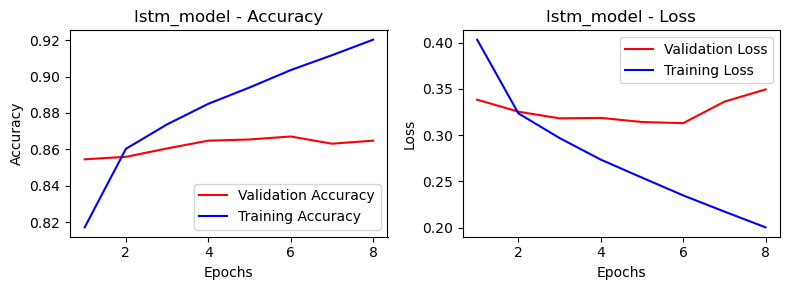

In [62]:
for i, history_dict in enumerate(history_list):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(acc) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(8, 3))

    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs, y=val_acc, c='r', label='Validation Accuracy')
    sns.lineplot(x=epochs, y=acc, c='b', label='Training Accuracy')
    plt.title('{} - Accuracy'.format(model_name_list[i]))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs, y=val_loss, c='r', label='Validation Loss')
    sns.lineplot(x=epochs, y=loss, c='b', label='Training Loss')
    plt.title('{} - Loss'.format(model_name_list[i]))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

## FastText 를 활용하여 성능 개선

In [63]:
import fasttext

In [64]:
#fasttext 훈련용  Data Set Decoding
X_train_d = get_decoded_sentences(X_train, index_to_word)
X_test_d = get_decoded_sentences(X_test,index_to_word)

data_set = X_test_d + X_train_d 

In [65]:
with open('data.txt', 'w', encoding='utf-8') as file:
    for sentence in data_set:
        file.write(sentence + '\n')

ft_model = fasttext.train_unsupervised('data.txt')

Read 11M words
Number of words:  9999
Number of labels: 0
Progress: 100.0% words/sec/thread:  575831 lr:  0.000000 avg.loss:  2.243726 ETA:   0h 0m 0s 2.243726 ETA:   0h 0m 0s


In [66]:
# 학습된 FastText 모델로부터 임베딩 얻기
word_to_vec_map = {word: ft_model[word] for word in ft_model.words}

In [67]:
vocab_size = len(word_to_index) 
embedding_dim = ft_model.get_dimension()  

embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [68]:
# FastText 모델로부터 얻은 임베딩으로 임베딩 행렬 채우기
for word, i in word_to_vec_map.items():
    if word in word_to_index:
        idx = word_to_index[word]
        embedding_vector = word_to_vec_map[word]
        embedding_matrix[idx] = embedding_vector

### LSTM

In [69]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),
                                         input_length=maxlen,trainable=True ))
lstm_model.add(tf.keras.layers.LSTM(64))
lstm_model.add(tf.keras.layers.Dense(8, activation='relu'))
lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 61, 100)           1000000   
                                                                 
 lstm_4 (LSTM)               (None, 64)                42240     
                                                                 
 dense_12 (Dense)            (None, 8)                 520       
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,042,769
Trainable params: 1,042,769
Non-trainable params: 0
_________________________________________________________________


In [70]:
early_stop = EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=7) #10-> 7

lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = lstm_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
229/229 [==============================] - 51s 216ms/step - loss: 0.3988 - accuracy: 0.8223 - val_loss: 0.3582 - val_accuracy: 0.8427
Epoch 2/50
229/229 [==============================] - 48s 211ms/step - loss: 0.3211 - accuracy: 0.8610 - val_loss: 0.3197 - val_accuracy: 0.8616
Epoch 3/50
229/229 [==============================] - 49s 215ms/step - loss: 0.2945 - accuracy: 0.8736 - val_loss: 0.3148 - val_accuracy: 0.8643
Epoch 4/50
229/229 [==============================] - 49s 213ms/step - loss: 0.2737 - accuracy: 0.8843 - val_loss: 0.3112 - val_accuracy: 0.8669
Epoch 5/50
229/229 [==============================] - 49s 214ms/step - loss: 0.2530 - accuracy: 0.8933 - val_loss: 0.3331 - val_accuracy: 0.8572
Epoch 6/50
229/229 [==============================] - 50s 218ms/step - loss: 0.2325 - accuracy: 0.9029 - val_loss: 0.3251 - val_accuracy: 0.8655
Epoch 7/50
229/229 [==============================] - 49s 215ms/step - loss: 0.2141 - accuracy: 0.9123 - val_loss: 0.3460 - val_ac

In [71]:
lstm_results = lstm_model.evaluate(X_test,  y_test, verbose=2)
lstm_history_dict = history.history

print(lstm_results)

1537/1537 - 13s - loss: 0.3505 - accuracy: 0.8598 - 13s/epoch - 9ms/step
[0.3504685163497925, 0.8597554564476013]


In [72]:
# loss: 0.3909 - accuracy: 0.8595

In [73]:
model_dic = {'lstm_model':lstm_model 
             #,'dcnn_model':dcnn_model,'gmp_model':gmp_model
            }
model_list = list(model_dic.values())
model_name_list = list(model_dic.keys())
history_list = [lstm_history_dict,
                #dcnn_history_dict ,gmp_history_dict
               ]

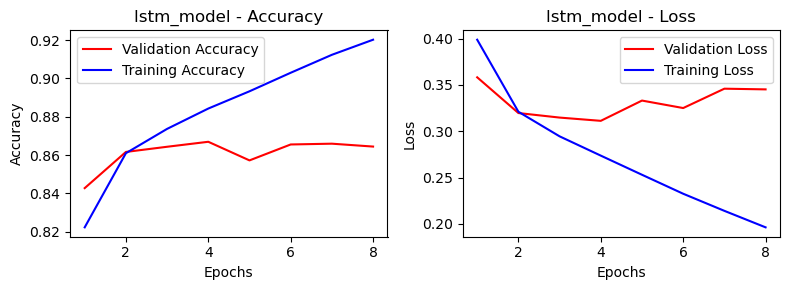

In [74]:
for i, history_dict in enumerate(history_list):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(acc) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(8, 3))

    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs, y=val_acc, c='r', label='Validation Accuracy')
    sns.lineplot(x=epochs, y=acc, c='b', label='Training Accuracy')
    plt.title('{} - Accuracy'.format(model_name_list[i]))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs, y=val_loss, c='r', label='Validation Loss')
    sns.lineplot(x=epochs, y=loss, c='b', label='Training Loss')
    plt.title('{} - Loss'.format(model_name_list[i]))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Report( Final Best Score :  8600)

#### 8600 (Word2Vec - LSTM)
#### 8598 (FastText - LSTM)
 1. Early Stop Option 
    - 과적합이 일어나기 쉬운 모델이라, 각 모델에 Loss 가 떨어지기 전 Early Stop Option 이 결과값에 중요했다.
 2. Stop_Words 제거 등
    - 전처리 과정(Stop_Words) 보다는 모델에 맡겨두는 것이 성능이 더 좋았다
 3. 사전 임베딩 레이어 전이 학습은 중요했다. 
    - Word2Vec , FastText 적용은 기존 모델보다 성능이 좋았다. 
---
 1. Try Option 
    - Word_Count 조정 :10000 -> 20000 (Total Word_Count - 5만 대)
    - 초기 Word Dim 조정 : 16 -> ?
 2. 가장 많이 쓰이는 단어 선정 보다, 의미 있는 단어 선정이 더 중요하지 않을까? (ex - TF-IDF)